# Проект e-commerce: вариант 1 

In [1]:
#импортируем все библиотеки, которые понадобятся нам для выполнения проекта
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
#считываем исходные данные и записываем их в датафреймы с аналогичными названиями
customers =   pd.read_csv('olist_customers_dataset.csv') 
order_items = pd.read_csv('olist_order_items_dataset.csv') 
orders =      pd.read_csv('olist_orders_dataset.csv') 

##### Постановка задач:

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?  

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?  

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.  

6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

Сперва проведём разведочный анализ данных - изучим предоставленные исходные данные.

Посмотрим на количество записей в каждом датасете и проверим на наличие дубликатов:

In [3]:
customers.shape #проверяем размер датафрейма customers

(99441, 5)

In [4]:
customers = customers.drop_duplicates()
customers.shape
#Как видим, данные о пользователях не содержат дубликатов

(99441, 5)

In [5]:
order_items.shape #проверяем размер датафрейма с товарными позициями

(112650, 7)

In [6]:
order_items = order_items.drop_duplicates()
order_items.shape
#Данные о товарных позициях также  не содержат дубликатов

(112650, 7)

In [7]:
orders.shape #проверяем размер датафрейма с данными о заказах

(99441, 8)

In [8]:
orders = orders.drop_duplicates()
orders.shape
#Данные о заказах также не содержат дубликатов

(99441, 8)

Проверим информацию о столбцах наших датафреймов с помощью функции df.info

In [9]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.6+ MB


В данном случае в столбцах датафрейма customers нет пропущенных значений и все столбцы имеют соответствующий формат данных.

In [10]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.9+ MB


В столбцах датафрейма order_items нет пропущенных значений, однако заметим, что столбец shipping_limit_date 
(максимальная дата доставки продавцом для передачи заказа партнеру по логистике) имеет тип данных object.

Приведём столбец 'shipping_limit_date' к формату datetime:

In [11]:
order_items['shipping_limit_date'] = pd.to_datetime(order_items['shipping_limit_date'])

Проверим, что тип данных в столбце 'shipping_limit_date' изменился на datetime64[ns]:

In [12]:
order_items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [13]:
# Продолжим анализировать данные в датафрейме orders
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.8+ MB


Заметим, что в столбцах есть пропущенные значения и столбцы с датами имеют тип object.

In [14]:
#Посчитаем количество пропущенных значений в каждом столбце.
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Проанализируем это. 

Пропущенные значения в столбце order_approved_at (время подтверждения оплаты заказа) могут означать то, что не все заказы, которые создали пользователи, были ими оплачены, что в принципе является нормой.

Посмотрим, какие статусы заказов присутствуют в наших данных:

In [15]:
orders.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

На основании того, что заказы в наших данных находятся в различных статусах (от только созданных до уже доставленных, отмененных и недоступных), мы можем сделать вывод, что наличие пропущенных значений в остальных столбцах в данном случае является нормой и удалять строки с пропущенными значениями нет необходимости. 

Приведем столбцы order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date и order_estimated_delivery_date
к типу данных datetime, т.к. в исходных данных их тип - object.

In [16]:
orders['order_purchase_timestamp']      = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at']             = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date']  = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

Проверим, что тип везде изменился на datetime64[ns].

In [17]:
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

Теперь данные готовы к дальнейшему использованию в решении задач.

### 1. Сколько у нас пользователей, которые совершили покупку только один раз?  

О том, что пользователь совершил покупку, нам будет свидетельствовать факт подтверждения оплаты заказа. Но, т.к. уникальные статусы заказов в таблице olist_orders_dataset не содержат в себе статуса "оплачен", то будем считать, что сборка заказа, как и во всех интернет-магазинах, будет осуществляться только после выставления клиенту счёта и получения магазином оплаты. Поэтому запишем в новый датафрейм paid_orders информацию только о тех заказах, которые были оплачены: то есть нам подойдут только статусы processing —  "в процессе сборки заказа", shipped —  "отгружен со склада", delivered —  "доставлен пользователю". Заказы со статусами unavailable —  "недоступен" и canceled —  "отменён" учитывать не будем.

In [18]:
paid_orders = orders.query("order_status in ('processing', 'shipped', 'delivered')")
paid_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [19]:
paid_orders.shape

(97886, 8)

В наших данных есть такая особенность, что customer_id — это позаказный идентификатор пользователя (то есть один и тот же человек, совершая разные заказы, будет иметь разные customer_id), то нам для решения данной задачи необходимо добраться до customer_unique_id —  уникального идентификатора пользователя  (аналога номера паспорта). 

customer_unique_id не представлены в таблице orders, они хранятся в датасете customers, поэтому объединим эти датафреймы по колонке customer_id, используя merge. Назовём получившийся датафрейм full_orders.

In [20]:
full_orders = paid_orders.merge(customers, how='left', on='customer_id')
full_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [21]:
#Проверим, что не потеряли какие-то заказы
full_orders.shape

(97886, 12)

Всё верно, кол-во строк совпадает с исходным датафреймом paid_orders, а кол-во столбцов увеличилось, т.к. прибавились столбцы из customers.

Теперь сгруппируем данные по customer_unique_id и посчитаем количество заказов для каждого кастомера, результат запишем в датафрейм customers_by_orders.

In [22]:
customers_by_orders = full_orders.groupby('customer_unique_id', as_index=False)\
.agg({'order_id':'count'})     
customers_by_orders.head()

,customer_unique_id,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [23]:
#Переименуем столбец с посчитанным кол-вом заказов в более логичное "orders_amount"
customers_by_orders.rename(columns = {'order_id' : 'orders_amount'}, inplace = True)
customers_by_orders

,customer_unique_id,orders_amount
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
94681,fffcf5a5ff07b0908bd4e2dbc735a684,1
94682,fffea47cd6d3cc0a88bd621562a9d061,1
94683,ffff371b4d645b6ecea244b27531430a,1
94684,ffff5962728ec6157033ef9805bacc48,1


Отберём только тех customer_unique_id, кто сделал 1 заказ и запишем результат в датафрейм one_order.

In [24]:
one_order = customers_by_orders.query('orders_amount == 1')

Теперь осталось узнать, сколько же было этих пользователей, которые совершили покупку только один раз.

In [25]:
one_order.shape

(91814, 2)

##### Выводы:
Таким образом, 91814 пользователей совершили покупку только один раз.

Посчитаем, сколько процентов пользователей сделали всего 1 заказ:

In [26]:
one_order.shape[0]*100/customers_by_orders.shape[0]

96.96681663603911

Почти 97% заказывали единожды, что очень много. Данному интернет-магазину следует задуматься над тем, как удерживать своих клиентов.

### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Для того, чтобы решить данную задачу, нам требуется сперва определить, что в ней означает то, что заказ не доставляется. Т.к мы будем анализировать в разрезе месяцов, то, принимая во внимание тот факт, что доставка всегда занимает разное кол-во времени, и что у разных пользователей может быть разные промежутки времени между созданием заказов и, например, оплатой, логично будет учесть все статусы заказов, кроме явного "delivered" —  доставлен пользователю. 

Таким образом, мы будем фильтровать заказы по статусам: 

    "created" —  создан
    "approved" —  подтверждён
    "invoiced" —  выставлен счёт
    "processing" —  в процессе сборки заказа
    "shipped" —  отгружен со склада
    "unavailable" —  недоступен
    "canceled" —  отменён.

Для начала отберём заказы с этими статусами из таблицы orders и запишем результат в таблицу not_delivered.

In [27]:
not_delivered = orders.query("order_status in ('created', 'approved', 'invoiced', 'processing', 'shipped', 'unavailable', 'canceled')")

Создадим колонку 'month', которая будет отражать месяц и год. Здесь важно обозначить, что месяца мы будем брать из колонки "order_estimated_delivery_date — обещанная дата доставки", т.к. данная дата есть у заказа каждого из выбранного нами статусов, и данная дата хорошо согласуется с поставленной задачей. Год выводим, потому что у нас данные за несколько лет, и, если мы не сделаем поправку на год, при дальнейшей группировке мы получим результат за каждый месяц сразу нескольких лет, что будет не совсем правильно. 

In [28]:
not_delivered['month'] = not_delivered.order_estimated_delivery_date.dt.to_period("M")
not_delivered.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,2017-05
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,2018-06
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21,2018-08
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03,2017-10
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07,2018-02


Проверим, сколько всего месяцов попало в наши данные.

In [29]:
not_delivered.month.nunique()

26

Итого 26 месяцов.

Теперь сгруппируем данные по статусу заказа и подсчитаем для них кол-во заказов за всё время.

In [30]:
not_delivered_groupped = not_delivered.groupby('order_status', as_index=False).agg({'order_id':'count'})
not_delivered_groupped

,order_status,order_id
0,approved,2
1,canceled,625
2,created,5
3,invoiced,314
4,processing,301
5,shipped,1107
6,unavailable,609


Теперь нам осталось вывести детализацию причин недоставления заказов в среднем за месяц. 

Добавим новую колнку 'avg_per_month', в которой произведем следующие вычисления: кол-во заказов всего поделим на количество месяцов (ранее мы подсчитали, что месяцов всего 26).

In [31]:
not_delivered_groupped['avg_per_month'] = not_delivered_groupped.order_id/26
not_delivered_groupped

,order_status,order_id,avg_per_month
0,approved,2,0.076923
1,canceled,625,24.038462
2,created,5,0.192308
3,invoiced,314,12.076923
4,processing,301,11.576923
5,shipped,1107,42.576923
6,unavailable,609,23.423077


Округлим значения средних до сотых и отсортируем по убыванию среднего значения.

In [32]:
not_delivered_groupped['avg_per_month'] = not_delivered_groupped.avg_per_month.round(2)
not_delivered_groupped.sort_values('avg_per_month', ascending=False)

,order_status,order_id,avg_per_month
5,shipped,1107,42.58
1,canceled,625,24.04
6,unavailable,609,23.42
3,invoiced,314,12.08
4,processing,301,11.58
2,created,5,0.19
0,approved,2,0.08


##### Выводы:
самая главная причина недоставления заказов — это то, что заказ отгружен со склада и находится в пути к клиенту. Такая формулировка звучит не совсем понятно, но для бизнеса это бы означало, что процессы в компании налажены относительно нормально (с учётом имеющейся в нашем распоряжении информации), и большинство заказов  отгружались клиентам. 

Следующие по популярности 2 причины — это то, что заказы были отменены либо недоступны.

### 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

Изучим более подробно наши данные о  товарных позициях, входящих в заказы

In [33]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Посмотрим, сколько всего уникальных ид товаров (аналогов штрихкода) есть в наших данных.

In [34]:
order_items.product_id.nunique()

32951

In [35]:
order_items.shape

(112650, 7)

In [36]:
order_items.order_id.nunique()

98666

Отметим, что уникальных идентификаторов заказа (номеров чека) у нас меньше, чем всего строк в датафрейме. Это означает в чеках могут встречаться несколько разных товаров, что вполне нормально.

Для решения данной задачи нам надо установить понятие даты покупки. Как отмечалось ранее автором, покупка совершена, когда произведена оплата за заказ. Так что в данном задании мы тоже будем руководствоваться этой логикой и датой покупки будем считать "order_approved_at —  время подтверждения оплаты заказа".

In [37]:
orders_and_products = order_items.merge(orders, how='left', on='order_id')
orders_and_products.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17


Добавим к нашему датафрейму orders_and_products столбец с названием дня недели, в который была совершена покупка.

In [38]:
orders_and_products['day'] = orders_and_products.order_approved_at.dt.day_name()
orders_and_products.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,day
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,Wednesday
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,Sunday
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,Wednesday
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,Saturday


Теперь сгруппируем данные по продукту и дню и посчитаем количество заказов для каждого заказа в каждый день. Сгруппированный датафрейм назовём orders_weekdays.

In [39]:
orders_weekdays = orders_and_products.groupby(['product_id', 'day'], as_index=False)\
.agg({'order_id':'count'})\
.rename(columns={'order_id':'order_quantity'})
orders_weekdays.head()

,product_id,day,order_quantity
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Friday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1


Давайте посмотрим, какие уникальные значения количества покупов встречаются в orders_weekdays.

In [40]:
orders_weekdays.order_quantity.unique()

array([  1,   2,   3,   4,   6,   5,   8,   7,  15,  12,  14,  10,   9,
        16,  13,  26,  22,  18,  19,  31,  17,  11,  33,  30,  41,  37,
        45,  56,  46,  20,  28,  42,  23,  47,  40,  52,  27,  25,  49,
        43,  80,  75,  21,  29,  60,  57,  63,  53,  51,  58,  35,  87,
        48,  65,  89,  73,  39,  32,  36,  24,  68,  38,  54,  69,  50,
       105,  34,  74,  70,  67,  82,  96, 119])

Проверим, что всё получилось и продукты действительно существуют и мы не потеряли данные.

In [41]:
orders_weekdays.query('order_quantity == "63"')

,product_id,day,order_quantity
13580,389d119b48cf3043d311335e499d9c6b,Thursday,63
50184,d1c427060a0f73f6b889a5c7c61f2ac4,Tuesday,63


In [42]:
#Запомним, сколько всего было уникальных продуктов 
orders_weekdays.product_id.nunique()

32948

Теперь сделаем сводную таблицу с  заполнением пропущенных значений на нули и выводом в качестве итога максимума по строке.

In [43]:
pivot = orders_weekdays.pivot_table('order_quantity', index='product_id', columns='day', aggfunc='max', fill_value=0, margins=True)
pivot

day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,All
product_id,,,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,0,0,0,1,0,0,0,1
00088930e925c41fd95ebfe695fd2655,0,0,0,0,0,1,0,1
0009406fd7479715e4bef61dd91f2462,1,0,0,0,0,0,0,1
000b8f95fcb9e0096488278317764d19,1,0,0,0,0,0,1,1
000d9be29b5207b54e86aa1b1ac54872,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...
fff81cc3158d2725c0655ab9ba0f712c,0,1,0,0,0,0,0,1
fff9553ac224cec9d15d49f5a263411f,0,0,1,0,0,0,0,1
fffdb2d0ec8d6a61f0a0a0db3f25b441,1,0,0,0,1,3,0,3


Теперь мы можем подствить любой интерсующий нас product_id в .query и узнать, сколько раз в каждый из дней недели этот product_id покупался и в какой день было совершено больше всего покупок. 

Последня колонка "All" будет показывать нам максимальное количество покупок, и, зная его, мы можем легко найти день недели, когда был самый большой спрос на товар.

Например, в уже замеченном нами ранее product_id == "389d119b48cf3043d311335e499d9c6b максимальное кол-во заказов было даже не 63, а 75, и это было во вторник (Tuesday).

In [44]:
pivot.query('product_id == "389d119b48cf3043d311335e499d9c6b"')

day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,All
product_id,,,,,,,,
389d119b48cf3043d311335e499d9c6b,60,43,57,41,63,75,53,75


А ещё мы можем увидеть, какой был самый популярный день для покупок по всем товарам (последняя строка All в pivot): и это тоже вторник (Tuesday).

### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

Здесь нам снова понадобится наш датафрейм full_orders, в котором записаны данные о покупках и клиентах.

Датой покупки также будем считать дату подтверждения оплаты order_approved_at.

Добавим новый столбец 'month', который будет отображать только год и номер мясаца из order_approved_at с помощью dt.to_period("M")

In [45]:
full_orders['month'] = full_orders.order_approved_at.dt.to_period("M")
full_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02


Далее создадим столбец 'weeks_in_month', в котором будет рассчитано кол-во недель в каждом месяце путём деления на 7 (кол-во дней в 1 неделе).

In [46]:
full_orders['weeks_in_month'] = full_orders.order_approved_at.dt.days_in_month / 7

Теперь сгруппируем данные по 'customer_unique_id', 'month' и 'weeks_in_month' и подсчитаем общее кол-во заказов. Полученный аггрегированный столбец переименуем в 'orders_quantity_in_month'. Новый датафрейм назовём orders_by_month.

In [47]:
orders_by_month = full_orders.groupby(['customer_unique_id', 'month', 'weeks_in_month'], as_index=False)\
.agg({'order_id':'count'})\
.rename(columns={'order_id':'orders_quantity_in_month'})
orders_by_month

,customer_unique_id,month,weeks_in_month,orders_quantity_in_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,4.428571,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,4.428571,1
2,0000f46a3911fa3c0805444483337064,2017-03,4.428571,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,4.428571,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11,4.285714,1
...,...,...,...,...
96536,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,4.285714,1
96537,fffea47cd6d3cc0a88bd621562a9d061,2017-12,4.428571,1
96538,ffff371b4d645b6ecea244b27531430a,2017-02,4.000000,1
96539,ffff5962728ec6157033ef9805bacc48,2018-05,4.428571,1


Теперь осталось высчитать среднее кол-во заказов в неделю (по месяцам):

In [48]:
orders_by_month['avg_orders_by_week'] = orders_by_month.orders_quantity_in_month / orders_by_month.weeks_in_month
orders_by_month

,customer_unique_id,month,weeks_in_month,orders_quantity_in_month,avg_orders_by_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,4.428571,1,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,4.428571,1,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,4.428571,1,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,4.428571,1,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11,4.285714,1,0.233333
...,...,...,...,...,...
96536,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,4.285714,1,0.233333
96537,fffea47cd6d3cc0a88bd621562a9d061,2017-12,4.428571,1,0.225806
96538,ffff371b4d645b6ecea244b27531430a,2017-02,4.000000,1,0.250000
96539,ffff5962728ec6157033ef9805bacc48,2018-05,4.428571,1,0.225806


Посмотрим на самые популярные и самые редкие значения avg_orders_by_week:

In [49]:
orders_by_month.avg_orders_by_week.value_counts()

0.225806    58141
0.233333    29195
0.250000     7936
0.451613      726
0.466667      330
0.500000      161
0.677419       25
0.700000       13
0.750000        6
1.000000        3
0.903226        2
0.933333        2
1.354839        1
Name: avg_orders_by_week, dtype: int64

##### Вывод: 
    большинство клиентов делали 1 заказ в месяц, поэтому среднее кол-во заказов в неделю (по месяцам) меньше 1. 

### 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

Как ранее отмечалось автором, в наших данных предоставлена отчетность не за один год. Давайте ещё раз взглянем, подтверждения оплат заказов за какое количество лет есть в наших данных.

In [50]:
full_orders.order_approved_at.dt.to_period("Y").nunique()

3

Итак, у нас всего информация по 3 разным годам. В формулировке задания не сказано, период с января по декабрь за какой именно год необходимо учитывать, поэтому автор данной работы принял решение делать анализ пользователей  в период с января по декабрь за 2017-й год. 

Также необходимо ввести понятие Retention Rate — коэффициент удержания клиентов. Будем рассчитывать его по месяцам.

Будем работать с таблицей full_orders.

Датой активности клиента будет order_purchase_timestamp  —  время создания заказа.

Для начала отфильтруем данные только за 2017й год с помощью query. Оставшиеся после фильтрации данные запишем в датафрейм orders_2017.

In [51]:
orders_2017 = full_orders.query("order_purchase_timestamp >= '2017-01-01' and order_purchase_timestamp<= '2017-12-31'")
orders_2017.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,month,weeks_in_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10,4.428571
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11,4.285714
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR,2017-07,4.428571
6,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,932afa1e708222e5821dac9cd5db4cae,26525,nilopolis,RJ,2017-05,4.428571
7,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06,39382392765b6dc74812866ee5ee92a7,99655,faxinalzinho,RS,2017-01,4.428571


Теперь нам нужно узнать, когда каждый из пользователей совершил свою первую покупку. Это в дальнейшем нам потребуется для формирования когорт.

Сгруппируем данные по уникальным id наших пользователей и высчитаем для каждого дату первой покупки (то есть "минимальную" дату с помощью аггрегации). Полученную информацию запишем в датафрейм first_orders. Рассчитанный столбец с минимальной датой переименуем в 'first_order_date'.

In [52]:
first_orders = orders_2017.groupby('customer_unique_id')\
.agg({'order_purchase_timestamp':'min'})\
.rename(columns={'order_purchase_timestamp':'first_order_date'})
first_orders.head()

,first_order_date
customer_unique_id,
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42
0005e1862207bf6ccc02e4228effd9a0,2017-03-04 23:32:12
0006fdc98a402fceb4eb0ee528f6a8d4,2017-07-18 09:23:10


Теперь, используя .merge объединим исходный датафрейм orders_2017 с first_orders для получения необходимых нам данных для дальнейшего выполнения задания.

In [53]:
orders_merged = orders_2017.merge(first_orders, how='inner', on = 'customer_unique_id')
orders_merged.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,month,weeks_in_month,first_order_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10,4.428571,2017-09-04 11:26:38
1,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-09,4.285714,2017-09-04 11:26:38
2,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11,4.285714,2017-11-18 19:28:06


Нам не важны дни, часы, минуты и секудны как моментов совершения первого заказа, так и всех заказов в целом, поэтому приведём колонки first_order_date и order_purchase_timestamp к виду "год-месяц", используя .dt.to_period("M").

In [54]:
orders_merged['first_order_month'] = orders_merged.first_order_date.dt.to_period("M")
orders_merged['order_date'] = orders_merged.order_purchase_timestamp.dt.to_period("M")

Проверим, как теперь выглядят столбцы (измененные столбцы в правой стороне датафрейма в конце).

In [55]:
orders_merged.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,month,weeks_in_month,first_order_date,first_order_month,order_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10,4.428571,2017-09-04 11:26:38,2017-09,2017-10
1,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-09,4.285714,2017-09-04 11:26:38,2017-09,2017-09
2,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11,4.285714,2017-11-18 19:28:06,2017-11,2017-11


Пришло время формировать когорты.
Сгруппируем данные по месяцу первого заказа (когорте), а затем по дате заказа для каждого пользователя, и посчитаем количество активных пользователей. Полученный датафрейм назовём cohorts.

In [56]:
cohorts = orders_merged.groupby(['first_order_month', 'order_date']).agg({'customer_unique_id':'count'})
cohorts

customer_unique_id
first_order_month order_date                    
2017-01           2017-01                    775
                  2017-02                      3
                  2017-03                      2
                  2017-04                      1
                  2017-05                      3
...                                          ...
2017-10           2017-11                     33
                  2017-12                     11
2017-11           2017-11                   7257
                  2017-12                     42
2017-12           2017-12                   5413

[77 rows x 1 columns]

Добавим порядковое значение CohortPeriod для каждого из OrderPeriod.
CohortPeriod определим как порядковый номер месяца в массиве начинающийся с 1.

In [57]:
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts

customer_unique_id  cohort_period
first_order_month order_date                                   
2017-01           2017-01                    775              1
                  2017-02                      3              2
                  2017-03                      2              3
                  2017-04                      1              4
                  2017-05                      3              5
...                                          ...            ...
2017-10           2017-11                     33              2
                  2017-12                     11              3
2017-11           2017-11                   7257              1
                  2017-12                     42              2
2017-12           2017-12                   5413              1

[77 rows x 2 columns]

Теперь сформируем сводную таблицу, которая будет более наглядно интерпретировать результат.

In [58]:
cohorts_pivot = cohorts.pivot_table(index='first_order_month', columns='cohort_period', values='customer_unique_id')
cohorts_pivot

cohort_period,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,
2017-01,775.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,3.0,1.0
2017-02,1703.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0
2017-03,2608.0,14.0,9.0,12.0,9.0,4.0,4.0,8.0,9.0,2.0,NaN
2017-04,2342.0,15.0,6.0,5.0,7.0,6.0,9.0,7.0,7.0,NaN,NaN
2017-05,3595.0,18.0,18.0,14.0,11.0,14.0,17.0,5.0,NaN,NaN,NaN
2017-06,3150.0,14.0,12.0,12.0,8.0,11.0,11.0,NaN,NaN,NaN,NaN
2017-07,3888.0,22.0,13.0,9.0,13.0,8.0,NaN,NaN,NaN,NaN,NaN
2017-08,4188.0,29.0,16.0,11.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4131.0,28.0,22.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Запишем в all исходное кол-во пользователей в первый месяц для каждой когорты.

In [59]:
all = cohorts_pivot[1]

Рассчитаем Retention Rate. Разделим количество активных пользователей в каждый из месяцев на исходное кол-во пользователей в когорте.

In [60]:
user_retention = cohorts_pivot.divide(all, axis=0)
user_retention

cohort_period,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,
2017-01,1.0,0.003871,0.002581,0.001290,0.003871,0.001290,0.003871,0.001290,0.001290,0.003871,0.001290
2017-02,1.0,0.002349,0.002936,0.001174,0.004110,0.001174,0.002349,0.001762,0.001174,0.001762,0.001174
2017-03,1.0,0.005368,0.003451,0.004601,0.003451,0.001534,0.001534,0.003067,0.003451,0.000767,NaN
2017-04,1.0,0.006405,0.002562,0.002135,0.002989,0.002562,0.003843,0.002989,0.002989,NaN,NaN
2017-05,1.0,0.005007,0.005007,0.003894,0.003060,0.003894,0.004729,0.001391,NaN,NaN,NaN
2017-06,1.0,0.004444,0.003810,0.003810,0.002540,0.003492,0.003492,NaN,NaN,NaN,NaN
2017-07,1.0,0.005658,0.003344,0.002315,0.003344,0.002058,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.006925,0.003820,0.002627,0.003582,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.006778,0.005326,0.003631,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Визуализируем полученную информацию. Выведем тепловую карту, оставим 3 знака после точки для всех значений.

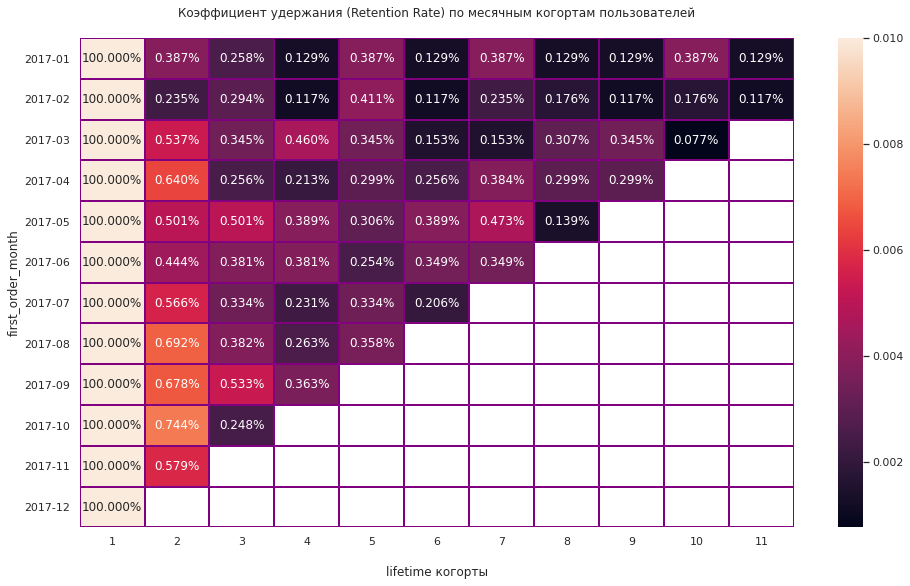

In [61]:
sns.set(style='white')
plt.figure(figsize=(16, 9))
plt.title('Коэффициент удержания (Retention Rate) по месячным когортам пользователей\n')
sns.heatmap(user_retention, annot=True, fmt='.3%', vmax = 0.01, linewidths=1, linecolor='purple')\
.set_xlabel('\nlifetime когорты')
plt.show()

Осталось только ответить на вопрос задачи - выявить когорту с самым высоким retention на 3й месяц.

Поэтому выведем индекс той строки (когорты), у которой был максимальный Retention Rate на 3й месяц.

In [62]:
user_retention[3].idxmax()

Period('2017-09', 'M')

##### Вывод: большинство покупателей делали покупки однократно. Лишь очень маленький процент пользователей возращались в данный интернет-магазин за повторными покупкам даже на следующий месяц с даты первой покупки. 
В период с января по декабрь 2017-го года когортой с самым высоким retention на 3й месяц оказалась '2017-09'.

### 6.Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

Сразу оговорим, что датой покупки будем далее считать дату подтверждения оплаты заказа — order_approved_at.

Подумаем, какие столбцы нам понадобятся в итоговой таблице для построения RFM-сегментации пользователей:

    customer_unique_id,
    order_approved_at,
    order_id, 
    price.
    
Осталось собрать их воедино из нескольких таблиц.

Таблица full_orders, созданная на прошлых шагах, содержит все необходимые столбцы, кроме price.

In [63]:
full_orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,month,weeks_in_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10,4.428571
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07,4.428571
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08,4.428571


In [64]:
#Запомним, сколько уникальных клиентов у нас было до объединения таблиц.
full_orders.customer_unique_id.nunique()

94686

In [65]:
#print('Orders from {} to {}'.format(full_orders['order_approved_at'].min(),
                                    #full_orders['order_approved_at'].max()))

#Таким образом, нам необходимо проанализировать продажи практически ровно за 3 года.

Столбец price есть в таблице orders_and_products, которую также мы создавали ранее. Кроме того, эта таблица содержит столбец customer_id, по которому мы сможем смёрджить таблицы и получить итоговую с полным набором данных.

In [66]:
orders_and_products.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,day
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,Wednesday
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,Sunday


Смёрждим таблицы full_orders и orders_and_products по customer_id и результат запишем в новый датафрейм df:

In [67]:
df = full_orders.merge(orders_and_products, how='left', on='customer_id')
df

,order_id_x,customer_id,order_status_x,order_purchase_timestamp_x,order_approved_at_x,order_delivered_carrier_date_x,order_delivered_customer_date_x,order_estimated_delivery_date_x,customer_unique_id,customer_zip_code_prefix,...,shipping_limit_date,price,freight_value,order_status_y,order_purchase_timestamp_y,order_approved_at_y,order_delivered_carrier_date_y,order_delivered_customer_date_y,order_estimated_delivery_date_y,day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,2017-10-06 11:07:15,29.99,8.72,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,2018-07-30 03:24:27,118.70,22.76,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,Thursday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,2018-08-13 08:55:23,159.90,19.22,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,2017-11-23 19:45:59,45.00,27.20,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,2018-02-19 20:31:37,19.90,8.72,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111735,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,...,2018-02-12 13:10:37,174.90,20.10,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,Tuesday
111736,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,...,2017-09-05 15:04:16,205.99,65.02,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,Sunday
111737,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,...,2018-01-12 21:36:21,179.99,40.59,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,Monday
111738,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,...,2018-01-12 21:36:21,179.99,40.59,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,Monday


Проверим кол-во уникальных клиентов в новой таблице и убедимся, что никого не потеряли:

In [68]:
df.customer_unique_id.nunique()

94686

Новый датафрейм df содержит очень много столбцов, которые не понадобятся нам далее, поэтому решено взять только нужные колонки и записать их в датафрейм new. 

In [69]:
new = df[['order_id_x', 'order_approved_at_x', 'customer_unique_id', 'price']]\
.rename(columns=({'order_id_x':'order_id', 'order_approved_at_x':'order_approved_at' })) #переименовали колонки, чтобы убрать "иксы"
new.head(3)

,order_id,order_approved_at,customer_unique_id,price
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 03:24:27,af07308b275d755c9edb36a90c618231,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:55:23,3a653a41f6f9fc3d2a113cf8398680e8,159.90


Ещё раз убедимся, что и теперь никого из клиентов не потеряли:

In [70]:
new.customer_unique_id.nunique()

94686

Теперь займёмся расчётом метрик. Будем делать это в отдельных датафреймах.

In [71]:
#Считаем сумму покупок за всё время
money = new.groupby('customer_unique_id', as_index=False)\
.agg({'price':'sum'})\
.rename(columns=({'price':'monye_total'})) #переименовали столбец для лучшего понимания

In [72]:
money
#кол-во клиентов прежнее - 94686

,customer_unique_id,monye_total
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,0000f46a3911fa3c0805444483337064,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,25.99
4,0004aac84e0df4da2b147fca70cf8255,180.00
...,...,...
94681,fffcf5a5ff07b0908bd4e2dbc735a684,1570.00
94682,fffea47cd6d3cc0a88bd621562a9d061,64.89
94683,ffff371b4d645b6ecea244b27531430a,89.90
94684,ffff5962728ec6157033ef9805bacc48,115.00


In [73]:
#Считаем суммарное количество покупок у пользователя за всё время (группировка по клиенту, подсчёт кол-ва заказов, переименовали аггрегированный столбц в frequency)
frequency = new.groupby('customer_unique_id', as_index=False)\
.agg({'order_id':'count'})\
.rename(columns=({'order_id':'frequency'}))
frequency
#кол-во клиентов прежнее - 94686

,customer_unique_id,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
94681,fffcf5a5ff07b0908bd4e2dbc735a684,2
94682,fffea47cd6d3cc0a88bd621562a9d061,1
94683,ffff371b4d645b6ecea244b27531430a,1
94684,ffff5962728ec6157033ef9805bacc48,1


In [74]:
last = new.groupby('customer_unique_id', as_index=False).agg({'order_approved_at':'max'})

In [75]:
last

,customer_unique_id,order_approved_at
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52
...,...,...
94681,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:15:16
94682,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:16:20
94683,ffff371b4d645b6ecea244b27531430a,2017-02-07 16:02:44
94684,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:58:47


Осталось добавить столбец с рассчитаным временем от последней покупки пользователя до текущей даты (recency).

Так как исходные датасеты не самые свежие, вместо текущей даты будем использовать max дату + 1.

In [76]:
NOW = last['order_approved_at'].max() + timedelta(days=1)
NOW

Timestamp('2018-09-04 17:40:06')

In [77]:
#Считаем recency:
last['recency'] = last['order_approved_at'].apply(lambda x: (NOW - x).days)
last
#Все 94686 клиентов на месте

,customer_unique_id,order_approved_at,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18,117.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44,119.0
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,542.0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17,326.0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52,293.0
...,...,...,...
94681,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:15:16,452.0
94682,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:16:20,267.0
94683,ffff371b4d645b6ecea244b27531430a,2017-02-07 16:02:44,574.0
94684,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:58:47,125.0


Смёрждим таблицы frequency и money по customer_unique_id в одну таблицу fm:

In [78]:
fm = frequency.merge(money, how='left', on='customer_unique_id')

Теперь смёрждим таблицы fm и last по customer_unique_id и получим итоговую таблицу rfm со всеми рассчитанными метриками:

In [79]:
rfm = fm.merge(last, how='left', on='customer_unique_id')

In [80]:
rfm
#Все 94686 клиентов по прежнему на месте

,customer_unique_id,frequency,monye_total,order_approved_at,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,2018-05-10 11:11:18,117.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,2018-05-07 18:25:44,119.0
2,0000f46a3911fa3c0805444483337064,1,69.00,2017-03-10 21:05:03,542.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,2017-10-12 20:49:17,326.0
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,2017-11-14 20:06:52,293.0
...,...,...,...,...,...
94681,fffcf5a5ff07b0908bd4e2dbc735a684,2,1570.00,2017-06-08 21:15:16,452.0
94682,fffea47cd6d3cc0a88bd621562a9d061,1,64.89,2017-12-10 20:16:20,267.0
94683,ffff371b4d645b6ecea244b27531430a,1,89.90,2017-02-07 16:02:44,574.0
94684,ffff5962728ec6157033ef9805bacc48,1,115.00,2018-05-02 15:58:47,125.0


Теперь осталось определить границы метрик recency, frequency и monetary.

Вызовем метод .describe и посмотрим на несколько рассчитаных процентилей наших метрик.

In [81]:
rfm[['frequency','monye_total','recency']].describe(percentiles=[.20, .40, .60, .80, .90, .99])

,frequency,monye_total,recency
count,94686.000000,94686.000000,94673.00000
mean,1.180111,141.865374,243.28760
std,0.620183,215.712966,152.80218
min,1.000000,0.000000,1.00000
20%,1.000000,39.900000,98.00000
40%,1.000000,69.900000,182.00000
50%,1.000000,89.800000,224.00000
60%,1.000000,109.900000,273.00000
80%,1.000000,179.900000,388.00000
90%,2.000000,280.000000,472.00000


При вызове метода .describe было замечено, что кол-во значений в recency не соответствует кол-ву в frequency и monye_total. Это означает, что где-то было пропущена дата заказа. Принято решение избавиться от этих пропусков. 

In [82]:
rfm = rfm.dropna()

In [83]:
rfm

,customer_unique_id,frequency,monye_total,order_approved_at,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,2018-05-10 11:11:18,117.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,2018-05-07 18:25:44,119.0
2,0000f46a3911fa3c0805444483337064,1,69.00,2017-03-10 21:05:03,542.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,2017-10-12 20:49:17,326.0
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,2017-11-14 20:06:52,293.0
...,...,...,...,...,...
94681,fffcf5a5ff07b0908bd4e2dbc735a684,2,1570.00,2017-06-08 21:15:16,452.0
94682,fffea47cd6d3cc0a88bd621562a9d061,1,64.89,2017-12-10 20:16:20,267.0
94683,ffff371b4d645b6ecea244b27531430a,1,89.90,2017-02-07 16:02:44,574.0
94684,ffff5962728ec6157033ef9805bacc48,1,115.00,2018-05-02 15:58:47,125.0


Также при вызове описания было замечено, что минимальная сумма заказа из всех составляла 0 у.е. Скорее всего имела место ошибка или сбой в момент выгрузки отчетности, поэтому автор принял решение исключить данный заказ из анализа, чтобы он сказался негативным образом на статистических расчётах.

In [84]:
rfm = rfm.query("monye_total != '0'")

In [85]:
rfm.shape

(94672, 5)

Таким образом, мы убрали 1 клиента с общей суммой заказа 0.

Ещё раз вызовем метод .describe и посмотрим на получившиеся статистические выводы (округлим рез-ты до 2 знаков после точки).

In [86]:
rfm.describe(percentiles=[.20, .40, .60, .80, .90, .99]).round(2)

,frequency,monye_total,recency
count,94672.00,94672.00,94672.00
mean,1.18,141.87,243.28
std,0.62,215.72,152.80
min,1.00,0.85,1.00
20%,1.00,39.90,98.00
40%,1.00,69.90,182.00
50%,1.00,89.80,224.00
60%,1.00,109.90,273.00
80%,1.00,179.90,388.00
90%,2.00,280.00,472.00


##### Несколько важных замечаний:
1) Можно отметить значительную разницу между максимальным количеством заказов по клиенту и 99% процентами других клиентов, вероятно, клиентов с количеством заказов 4(не вкл.)-24 стоит выделить в отдельный RFM сегмент или имел место некоторый выброс данных.

2) А также можно отметить значительную разницу между максимальной суммой покупок за всё время и 99% сумм покупок за всё время других клиентов, вероятно, клиентов с суммой покупок за всё время 1004.99(не вкл.) - 13440 стоит выделить в отдельный RFM сегмент или имел место некоторый выброс данных.

3) Среднее по частоте заказов составляет 1.18 заказа, а процентили вплоть до 80 составляют 1, то есть большинство клиентов сделали всего 1 заказ.

4) Что касается значений recency, разумнее всего отслеживать и проводить какие-то мероприятия с теми клиентами, кто делал свои последние заказы менее года назад. В нашем случае 80й процентиль составляет 388 дней (примерно год), поэтому мы можем сказать, что примерно 80% наших клиентов делали последние заказы в течение года. 

##### На основании вышеизложенного автор принял решение, что для RFM-сегментации пользователей будем использовать 3 ранга и распределяться на основе процентилей: 80-го и 99-го.

Следовательно, мы можем установить следующие границы для frequency: 

    1 - от 0 до 1 заказа (туда попадут только те, кто сделал 1 заказ);
    2 - от 2 до 4 заказов;
    3 - от 5 до 24 заказов.

Границы для recency установим следующие:

    1 - от 1 дня до 388 дней;
    2 - от 389 дней до 580 дней;
    3 - от 581 дней до 719 дней.

Для monetary установим следующие границы:

    1 - от 0.85 до 179.90 у.е.
    2 - от 179.91 до 1004.99 у.е.
    3 - от 1005 до 13440 у.е.

Теперь нам осталось расставить значения r,f, и m  и затем присвоить RFM-сегмент каждому клиенту. 

In [87]:
quantiles = rfm.quantile(q=[0.80, 0.99])
quantiles = quantiles.to_dict()
segmented_rfm = rfm

Создаём функцию, которая сегментирует покупателей:

In [88]:
def RScore(x,p,d):
     if x <= d[p][0.80]:
         return 1
     elif x <= d[p][0.99]:
         return 2
     else: 
         return 3

Применяем созданную функцию, дополняя датафрейм segmented_rfm 3 новыми колонками 'R', 'F' и 'M', в которых проставятся ранги.

In [89]:
segmented_rfm['R'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['F'] = segmented_rfm['frequency'].apply(RScore, args=('frequency',quantiles,))
segmented_rfm['M'] = segmented_rfm['monye_total'].apply(RScore, args=('monye_total',quantiles,))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

Осталось создать RFM-сегменты для каждого клиента (соединяем ранги по каждому клиенту и выводим результат в отдельный столбец 'RFM'):

In [90]:
segmented_rfm['RFM'] = segmented_rfm.R.map(str) + segmented_rfm.F.map(str) + segmented_rfm.M.map(str)
segmented_rfm

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,customer_unique_id,frequency,monye_total,order_approved_at,recency,R,F,M,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,2018-05-10 11:11:18,117.0,1,1,1,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,2018-05-07 18:25:44,119.0,1,1,1,111
2,0000f46a3911fa3c0805444483337064,1,69.00,2017-03-10 21:05:03,542.0,2,1,1,211
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,2017-10-12 20:49:17,326.0,1,1,1,111
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,2017-11-14 20:06:52,293.0,1,1,2,112
...,...,...,...,...,...,...,...,...,...
94681,fffcf5a5ff07b0908bd4e2dbc735a684,2,1570.00,2017-06-08 21:15:16,452.0,2,2,3,223
94682,fffea47cd6d3cc0a88bd621562a9d061,1,64.89,2017-12-10 20:16:20,267.0,1,1,1,111
94683,ffff371b4d645b6ecea244b27531430a,1,89.90,2017-02-07 16:02:44,574.0,2,1,1,211
94684,ffff5962728ec6157033ef9805bacc48,1,115.00,2018-05-02 15:58:47,125.0,1,1,1,111


Посмотрим, сколько всего уникальных сегментов у нас получилось:

In [91]:
segmented_rfm.RFM.nunique()

26

Посмотрим на то, как распределились наши пользователи по сегментам: какие сегменты самые популярные, какие менее:

In [92]:
segmented_rfm.RFM.value_counts()

111    54952
211    13117
112    10659
121     5669
122     3296
212     2651
221     1279
222      705
311      619
113      601
132      309
312      168
213      136
123      122
131      120
321       69
133       48
322       43
232       31
231       27
223       24
331        8
332        7
313        7
233        4
323        1
Name: RFM, dtype: int64

Осталось для каждого RFM-сегмента построить границы метрик recency, frequency и monetary для интерпретации этих кластеров.

Будем идти от самого популярного к наименее популярному.

##### RFM-сегмент 111 (recency=1, frequency=1, monetary=1)
имеет границы метрик recency от 1 до 388 дней, frequency 1 заказ, monetary от 0.85 до 179.90 у.е.

##### RFM-сегмент 211 (recency=2, frequency=1, monetary=1)
имеет границы метрик recency от 389 до 580 дней, frequency 1 заказ, monetary от 0.85 до 179.90 у.е.

##### RFM-сегмент 112 (recency=1, frequency=1, monetary=2)
имеет границы метрик recency от 1 до 388 дней, frequency 1 заказ, monetary от 179.91 до 1004.99 у.е.

##### RFM-сегмент 121 (recency=1, frequency=2, monetary=1)
имеет границы метрик recency от 1 до 388 дней, frequency от 2 до 4 заказов, monetary от 0.85 до 179.90 у.е.

##### RFM-сегмент 122 (recency=1, frequency=2, monetary=2)
имеет границы метрик recency от 1 до 388 дней, frequency от 2 до 4 заказов, monetary от 179.91 до 1004.99 у.е.

##### RFM-сегмент 212 (recency=2, frequency=1, monetary=2)
имеет границы метрик recency от 389 до 580 дней, frequency 1 заказ, monetary от 179.91 до 1004.99 у.е.

##### RFM-сегмент 221 (recency=2, frequency=2, monetary=1)
имеет границы метрик recency от 389 до 580 дней, frequency от 2 до 4 заказов, monetary от 0.85 до 179.90 у.е.

##### RFM-сегмент 222 (recency=2, frequency=2, monetary=2)
имеет границы метрик recency от 389 до 580 дней, frequency от 2 до 4 заказов, monetary от 179.91 до 1004.99 у.е.

##### RFM-сегмент 311 (recency=3, frequency=1, monetary=1)
имеет границы метрик recency от 581 до 719 дней, frequency 1 заказ, monetary от 0.85 до 179.90 у.е.

##### RFM-сегмент 113 (recency=1, frequency=1, monetary=3)
имеет границы метрик recency от 1 до 388 дней, frequency 1 заказ, monetary от 1005 до 13440 у.е.

##### RFM-сегмент 132 (recency=1, frequency=3, monetary=2)
имеет границы метрик recency от 1 до 388 дней, frequency от 5 до 24 заказов, monetary от 179.91 до 1004.99 у.е.

##### RFM-сегмент 312 (recency=3, frequency=1, monetary=2)
имеет границы метрик recency от 581 до 719 дней, frequency 1 заказ, monetary от 179.91 до 1004.99 у.е.

##### RFM-сегмент 213 (recency=2, frequency=1, monetary=3)
имеет границы метрик recency от 389 до 580 дней, frequency 1 заказ, monetary от 1005 до 13440 у.е.

##### RFM-сегмент 123 (recency=1, frequency=2, monetary=3)
имеет границы метрик recency от 1 до 388 дней, frequency от 2 до 4 заказов, monetary от 1005 до 13440 у.е.

##### RFM-сегмент 131 (recency=1, frequency=3, monetary=1)
имеет границы метрик recency от 1 до 388 дней, frequency от 5 до 24 заказов, monetary от 0.85 до 179.90 у.е.

##### RFM-сегмент 321 (recency=3, frequency=2, monetary=1)
имеет границы метрик recency от 581 до 719 дней, frequency от 2 до 4 заказов, monetary от 0.85 до 179.90 у.е.

##### RFM-сегмент 133 (recency=1, frequency=3, monetary=3)
имеет границы метрик recency от 1 до 388 дней, frequency от 5 до 24 заказов, monetary от 1005 до 13440 у.е.

##### RFM-сегмент 322 (recency=3, frequency=2, monetary=2)
имеет границы метрик recency от 581 до 719 дней, frequency от 2 до 4 заказов, monetary от 179.91 до 1004.99 у.е.

##### RFM-сегмент 232 (recency=2, frequency=3, monetary=2)
имеет границы метрик recency от 389 до 580 дней, frequency от 5 до 24 заказов, monetary от 179.91 до 1004.99 у.е.

##### RFM-сегмент 231 (recency=2, frequency=3, monetary=1)
имеет границы метрик recency от 389 до 580 дней, frequency от 5 до 24 заказов, monetary от 0.85 до 179.90 у.е.

##### RFM-сегмент 223 (recency=2, frequency=2, monetary=3)
имеет границы метрик recency от 389 до 580 дней, frequency от 2 до 4 заказов, monetary от 1005 до 13440 у.е.

##### RFM-сегмент 331 (recency=3, frequency=3, monetary=1)
имеет границы метрик recency от 581 до 719 дней, frequency от 5 до 24 заказов, monetary от 0.85 до 179.90 у.е.

##### RFM-сегмент 313 (recency=3, frequency=1, monetary=3)
имеет границы метрик recency от 581 до 719 дней, frequency 1 заказ, monetary от 1005 до 13440 у.е.

##### RFM-сегмент 332 (recency=3, frequency=3, monetary=2)
имеет границы метрик recency от 581 до 719 дней, frequency от 5 до 24 заказов, monetary от 179.91 до 1004.99 у.е.

##### RFM-сегмент 233 (recency=2, frequency=3, monetary=3)
имеет границы метрик recency от 389 до 580 дней, frequency от 5 до 24 заказов, monetary от 1005 до 13440 у.е.

##### RFM-сегмент 323 (recency=3, frequency=2, monetary=3)
имеет границы метрик recency от 581 до 719 дней, frequency от 2 до 4 заказов, monetary от 1005 до 13440 у.е.

Как видим, самым частым оказался RFM-сегмент '111' , т.е. данные пользователи совершили всего 1 заказ, сделали это относительно недавно (в течение примерно 1 года) и купили на относительно небольшую сумму.